In [15]:
from matplotlib import pyplot as plt
import numpy as np
from case_studies import *

#uncomment for environments ike WSL that have no gui
#import matplotlib
#matplotlib.use('agg')


def conjugate_gradients(Q,g,epsilon):
    """
    Implements the Conjugate Gradient function that finds the approximate minimum of the function

    f(x) = 1/2 x^TQx + g^Tx

    Arguments:
    Q: A nxn positive definite matrix
    g: A n vector
    epsilon: the tolerance, the algorithm terminates when |grad f(x)|<epsilon

    Returns:
    x_k: the approximate optimum 
    x_k_history: A list of solution candidates x_k computes by CG
    """
    x_k = np.zeros(g.shape[0]) #algorithm starts at 0
    x_k_history=[x_k.copy()] #history of x values computed
    
    # Algorithm 5: Conjugate Gradients
    grad_k = g.copy()          # ∇f0 = g
    p_k = -grad_k              # p0 = -∇f0

    while True:
        Qp_k = Q @ p_k
        alpha_k = -(p_k @ grad_k) / (p_k @ Qp_k)   # αk = -(p_k^T ∇fk) / (p_k^T Q p_k)
        x_k = x_k + alpha_k * p_k                    # x_{k+1} = x_k + α_k p_k
        grad_k_next = Q @ x_k + g                    # ∇f_{k+1} = Q x_{k+1} + g
        x_k_history.append(x_k.copy())

        if np.linalg.norm(grad_k_next) < epsilon:    # stop if ||∇f_{k+1}|| < ε
            break

        # p_{k+1} = -∇f_{k+1} + (∇f_{k+1}^T Q p_k) / (p_k^T Q p_k) * p_k
        beta_k = (grad_k_next @ Qp_k) / (p_k @ Qp_k)
        p_k = -grad_k_next + beta_k * p_k
        grad_k = grad_k_next
        
    return x_k, x_k_history


numerical difference: 5.409990811380916e-13
grad norm: 5.949973157392661e-11


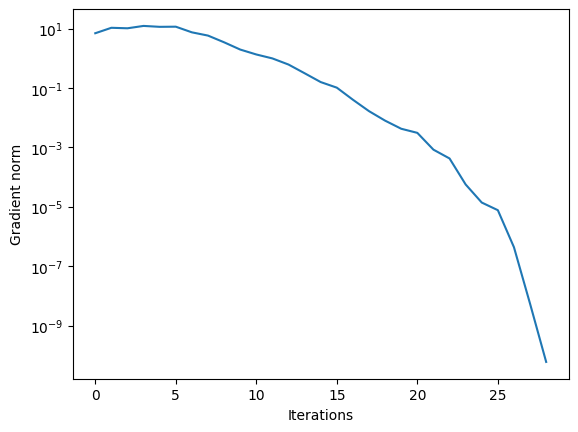

In [16]:
#setup problem 
n=50
epsilon=1.e-10
Q=np.random.randn(n,n//2)
Q=Q@Q.T +np.eye(n)
g = np.random.randn(n)

#analytical solution
solution = -np.linalg.inv(Q)@g 

#run algorithm
solution_cg, history = conjugate_gradients(Q,g,epsilon)

#test for correctness
print("numerical difference:", np.linalg.norm(solution-solution_cg))
grad_cg_sol = Q@solution_cg + g
print("grad norm:", np.linalg.norm(grad_cg_sol))

#plot the history
history_grad = [np.linalg.norm(Q@x + g) for x in history]
plt.semilogy(history_grad)
plt.ylabel("Gradient norm")
plt.xlabel("Iterations")
plt.savefig("results_cg.png")

In [17]:
def steepest_descent_wrapper(f, df, Hf, x0, max_iter, epsilon, rho=0.5, c1=1e-4):
    xs = []
    grad_norms = []
    i = 0
    b = 1
    x_current = x0.copy()
    def bt_LS(x, b, p_k):
        """Backtracking line search"""
        a = b
        while f(x + a*p_k) > f(x) + c1*a*df(x).T@p_k:
            a = rho*a
        return a
    while i < max_iter:
        grad = df(x_current)
        grad_norm = np.linalg.norm(grad)
        
        xs.append(x_current.copy())
        grad_norms.append(np.maximum(grad_norm, 1e-5*epsilon))    
        if grad_norm < epsilon:
            break
        p_k = -grad
        a_k = bt_LS(x_current, b, p_k)
        x_current = x_current + a_k*p_k
        i += 1
        b = a_k/rho
    return np.array(xs), np.array(grad_norms)


def newton_backtracking_eigenvalue(f, df, Hf, x0, max_iter, epsilon, rho=0.5, c1=1e-4):
    """
    Newton's Method following lecture slides pseudocode exactly.
    Uses eigenvalue modification: H_modified = Σ (1/|λᵢ|) vᵢvᵢᵀ
    
    This matches Algorithm 4 from the slides.
    """
    xs = []
    grad_norms = []
    
    i = 0
    b = 1
    x_current = x0.copy()
    
    def bt_LS(x, b, p_k):
        """Backtracking line search"""
        a = b
        while f(x + a*p_k) > f(x) + c1*a*df(x).T@p_k:
            a = rho*a
        return a
    
    def compute_newton_direction_eigenvalue(H, g):
        """
        Compute Newton direction following lecture slides.
        
        If H is positive definite: p = -H⁻¹g
        Else: Compute eigenvalues λᵢ and eigenvectors vᵢ
              H_modified = Σ (1/|λᵢ|) vᵢvᵢᵀ
              p = -H_modified · g
        """
        # Check if positive definite via Cholesky
        try:
            L = np.linalg.cholesky(H)
            y = np.linalg.solve(L, -g)
            p = np.linalg.solve(L.T, y)
            return p
        except np.linalg.LinAlgError:
            # H is not positive definite - use eigenvalue modification
            eigenvalues, eigenvectors = np.linalg.eigh(H)
            
            # Reconstruct with absolute values: H = Σ (1/|λᵢ|) vᵢvᵢᵀ
            # This is equivalent to: H_modified = V · diag(1/|λ|) · Vᵀ
            abs_inv_eigenvalues = 1.0 / np.abs(eigenvalues)
            
            # Compute H_modified · g efficiently without forming full matrix
            # H_modified · g = V · diag(1/|λ|) · Vᵀ · g
            temp = eigenvectors.T @ g  # Vᵀ · g
            temp = abs_inv_eigenvalues * temp  # diag(1/|λ|) · (Vᵀ · g)
            p = -(eigenvectors @ temp)  # -V · result
            
            return p
    
    while i < max_iter:
        grad = df(x_current)
        grad_norm = np.linalg.norm(grad)
        
        xs.append(x_current.copy())
        grad_norms.append(np.maximum(grad_norm, 1e-5*epsilon))
        
        if grad_norm < epsilon:
            break
        
        # Compute Hessian and get Newton direction
        hess = Hf(x_current)
        p_k = compute_newton_direction_eigenvalue(hess, grad)
        
        # Backtracking line search
        a_k = bt_LS(x_current, b, p_k)
        x_current = x_current + a_k*p_k
        i += 1
        b = a_k/rho
    
    return np.array(xs), np.array(grad_norms)







In [18]:
# ported from Handin2
import time
from collections import defaultdict

def generate_initial_points(x_optimal, n_points=100, variance=100, seed=42):
    """Generate initial points from N(x*, variance·I)"""
    np.random.seed(seed)
    dim = len(x_optimal)
    cov = variance * np.eye(dim)
    return np.random.multivariate_normal(x_optimal, cov, size=n_points)

def run_optimizer_with_tracking(optimizer, f, df, Hf, x0, x_opt_val, f_opt_val, max_iter, epsilon):
    """Run optimizer and track convergence metrics"""
    start_time = time.time()
    
    xs, grad_norms = optimizer(f, df, Hf, x0, max_iter, epsilon)
    
    elapsed_time = time.time() - start_time
    
    f_errors = np.array([f(x) - f_opt_val for x in xs])
    x_errors = np.array([np.linalg.norm(x - x_opt_val) for x in xs])
    
    return {
        'iterations': len(xs),
        'time': elapsed_time,
        'f_errors': f_errors,
        'x_errors': x_errors,
        'grad_norms': grad_norms
    }

def run_testing_protocol(function_suite, optimizers, n_initial_points=100, max_iter=1000, epsilon=1e-6):
    """Run complete testing protocol"""
    results = defaultdict(lambda: defaultdict(list))
    
    for func_name, f, df, Hf, dim in function_suite:
        x_opt_val = x_opt(func_name, dim)
        f_opt_val = f(x_opt_val)
        initial_points = generate_initial_points(x_opt_val, n_initial_points)
        
        for opt_name, optimizer in optimizers:
            for x0 in initial_points:
                try:
                    result = run_optimizer_with_tracking(
                        optimizer, f, df, Hf, x0, x_opt_val, f_opt_val, max_iter, epsilon
                    )
                    results[func_name][opt_name].append(result)
                except:
                    continue
    
    return results

def aggregate_run_statistics(run_results):
    """Aggregate runs to compute median, 75th percentile and 99th percentile."""
    error_lists = [np.abs(r['f_errors']) + 1e-20 for r in run_results]
    lengths = [len(e) for e in error_lists]
    max_len = max(lengths)
    
    # Pad shorter runs by repeating their final value (edge padding)
    padded = np.array([
        np.pad(e, (0, max_len - len(e)), mode='edge') if len(e) < max_len else e
        for e in error_lists
    ])
    
    # Step-wise statistics
    median_steps = np.percentile(padded, 50, axis=0)
    p75_steps = np.percentile(padded, 75, axis=0)
    p99_steps = np.percentile(padded, 99, axis=0)
    steps = np.arange(max_len)
    
    # Time grid: use same number of points as steps and span 0..max_time
    max_time = max(r['time'] for r in run_results)
    n_time_points = max_len
    time_grid = np.linspace(0, max_time, n_time_points)
    
    # Interpolate each run's (time, errors) onto time_grid
    interp_errors = []
    for r, e in zip(run_results, error_lists):
        times = np.linspace(0, r['time'], len(e))
        interp = np.interp(time_grid, times, e)
        interp_errors.append(interp)
    
    interp_arr = np.array(interp_errors)
    median_time = np.percentile(interp_arr, 50, axis=0)
    p75_time = np.percentile(interp_arr, 75, axis=0)
    p99_time = np.percentile(interp_arr, 99, axis=0)
    
    return {
        'steps': steps,
        'median_steps': median_steps,
        'p75_steps': p75_steps,
        'p99_steps': p99_steps,
        'time': time_grid,
        'median_time': median_time,
        'p75_time': p75_time,
        'p99_time': p99_time
    }

In [19]:
def inexact_newton(f, df, Hf, x0, max_iter, epsilon, rho=0.5, c1=1e-4):
    """
    Inexact Newton's Algorithm (Algorithm 6).
    Uses conjugate gradients to approximately solve the Newton system,
    with a forcing sequence eta_k that adapts to the gradient norm.

    Arguments:
    f       : objective function
    df      : gradient of f
    Hf      : Hessian of f
    x0      : starting point
    max_iter: maximum number of iterations
    epsilon : stopping tolerance (stop when ||∇f(x)|| < epsilon)
    rho     : backtracking factor (0 < rho < 1)
    c1      : sufficient decrease constant (0 < c1 < 1)

    Returns:
    xs          : array of iterates x_k
    grad_norms  : array of gradient norms at each iterate
    """
    xs = []
    grad_norms = []

    x_current = x0.copy()

    def bt_LS(x, p_k):
        """Backtracking line search starting from alpha=1.0"""
        a = 1.0
        while f(x + a * p_k) > f(x) + c1 * a * df(x) @ p_k:
            a = rho * a
        return a

    for k in range(max_iter):
        grad = df(x_current)
        grad_norm = np.linalg.norm(grad)

        xs.append(x_current.copy())
        grad_norms.append(np.maximum(grad_norm, 1e-5 * epsilon))

        if grad_norm < epsilon:
            break

        # Forcing sequence: eta_k = min(1/2, sqrt(||∇f(x_k)||))
        eta_k = 0.5 * min(0.5, np.sqrt(grad_norm))
        # Inner tolerance: epsilon_k = eta_k * ||∇f(x_k)||
        epsilon_k = eta_k * grad_norm

        # Approximately solve Newton system H_k * p_k ≈ -∇f(x_k) via CG
        H = Hf(x_current)
        p_k, _ = conjugate_gradients(H, grad, epsilon_k)

        # Backtracking line search starting from alpha=1.0
        a_k = bt_LS(x_current, p_k)
        x_current = x_current + a_k * p_k

    return np.array(xs), np.array(grad_norms)


In [20]:
# Define function suite for testing
function_suite_all = [
    ("f1", f1, df1, Hf1, 20),
    ("f4", f4, df4, Hf4, 20),
    ("f5", f5, df5, Hf5, 20)
]

# Define optimizers to test
optimizers_test = [
    ("Steepest-Descent", steepest_descent_wrapper),
    ("Newton-BT", newton_backtracking_eigenvalue),
    ("Inexact-Newton", inexact_newton)
]

# Run the testing protocol with all three optimizers
print("Running testing protocol on all functions with 3 optimizers...")
results_test = run_testing_protocol(function_suite_all, optimizers_test, 
                                    n_initial_points=3, max_iter=500, epsilon=1e-8)
print("✓ Testing protocol complete!")


Running testing protocol on all functions with 3 optimizers...
✓ Testing protocol complete!


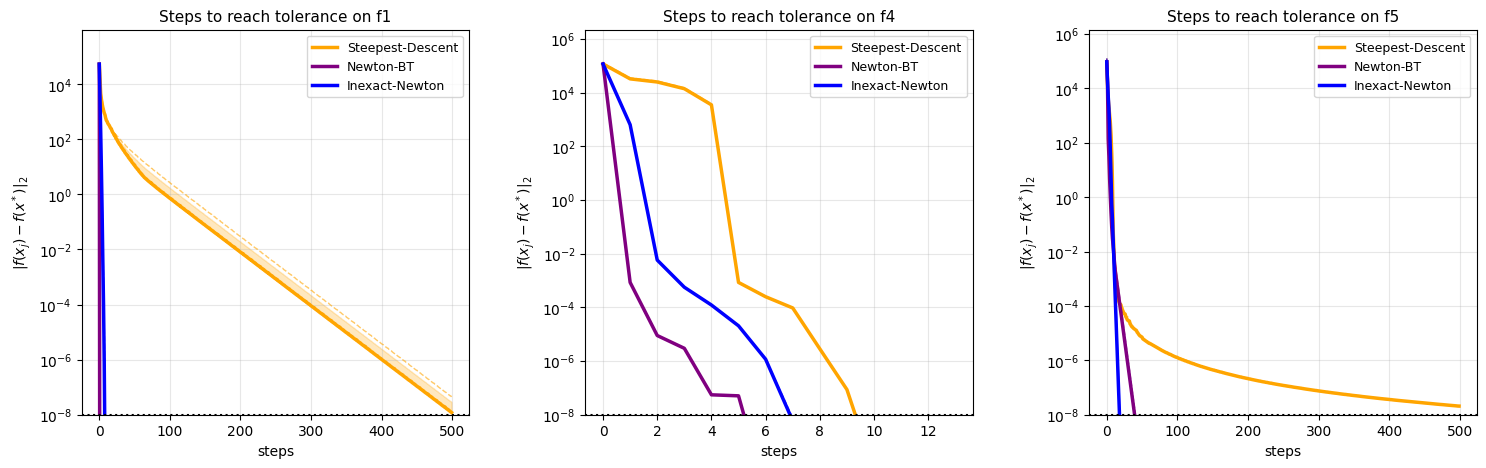


✓ Newton's Method comparison complete!


In [21]:
# Plot comparison for all functions - steps only, 1x3 layout
fig = plt.figure(figsize=(18, 5))
gs = fig.add_gridspec(1, 3, hspace=0.3, wspace=0.3)

colors = {'Steepest-Descent': 'orange', 'Newton-BT': 'purple', 'Inexact-Newton': 'blue'}
epsilon = 1e-8

# Create axes: [0], [1], [2]
axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[0, 2])
]

for idx, (func_name, _, _, _, _) in enumerate(function_suite_all):
    ax = axes[idx]
    
    for opt_name in ['Steepest-Descent', 'Newton-BT', 'Inexact-Newton']:
        run_results = results_test[func_name][opt_name]
        if not run_results:
            continue
        
        stats = aggregate_run_statistics(run_results)
        color = colors[opt_name]
        
        # Plot steps only
        ax.semilogy(stats['steps'], stats['median_steps'], 
                   color=color, linewidth=2.5, label=opt_name)
        ax.fill_between(stats['steps'], 
                       stats['median_steps'],
                       stats['p75_steps'],
                       color=color, alpha=0.25)
        ax.semilogy(stats['steps'], stats['p99_steps'], 
                   color=color, linewidth=1, linestyle='--', alpha=0.6)
    
    # Add epsilon line
    ax.axhline(y=epsilon, color='black', linestyle=':', linewidth=1.5)
    
    # Set limits
    ax.set_ylim(bottom=epsilon)
    
    # Format plot
    ax.set_xlabel('steps', fontsize=10)
    ax.set_ylabel(r'$|f(x_j) - f(x^*)|_2$', fontsize=10)
    ax.set_title(f'Steps to reach tolerance on {func_name}', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=9)

plt.show()

print("\n✓ Newton's Method comparison complete!")
